# Datablock API foundations

In [1]:
import math
import operator
import re
from collections import Iterable

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.nn.init as init
import torch.optim as optim
from fastai import datasets

In [2]:
device=torch.device('cuda',0)

# Get images

In [3]:
path = datasets.untar_data(datasets.URLs.IMAGENETTE_160)

# Image item list

In [4]:
import PIL, os, mimetypes
from pathlib import Path
Path.ls = lambda x: list(x.iterdir())

In [5]:
path.ls()

[PosixPath('/home/justin/.fastai/data/imagenette2-160/train'),
 PosixPath('/home/justin/.fastai/data/imagenette2-160/val')]

In [6]:
(path/'val').ls()

[PosixPath('/home/justin/.fastai/data/imagenette2-160/val/n03028079'),
 PosixPath('/home/justin/.fastai/data/imagenette2-160/val/n03417042'),
 PosixPath('/home/justin/.fastai/data/imagenette2-160/val/n03888257'),
 PosixPath('/home/justin/.fastai/data/imagenette2-160/val/n02979186'),
 PosixPath('/home/justin/.fastai/data/imagenette2-160/val/n03425413'),
 PosixPath('/home/justin/.fastai/data/imagenette2-160/val/n03000684'),
 PosixPath('/home/justin/.fastai/data/imagenette2-160/val/n01440764'),
 PosixPath('/home/justin/.fastai/data/imagenette2-160/val/n03394916'),
 PosixPath('/home/justin/.fastai/data/imagenette2-160/val/n02102040'),
 PosixPath('/home/justin/.fastai/data/imagenette2-160/val/n03445777')]

In [7]:
path_tench = path/'val'/'n01440764'

In [8]:
img_fn = path_tench.ls()[0]
img_fn

PosixPath('/home/justin/.fastai/data/imagenette2-160/val/n01440764/n01440764_7501.JPEG')

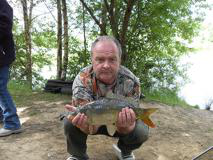

In [9]:
img = PIL.Image.open(img_fn)
img

In [10]:
import numpy
imga = numpy.array(img)

In [11]:
imga.shape

(160, 213, 3)

In [12]:
imga[:10, :10, 0]

array([[ 44,  39,  41,  51, ..., 156, 255, 255, 252],
       [ 36,  35,  37,  43, ..., 109, 187, 213, 194],
       [ 33,  38,  40,  43, ...,  67, 114, 232, 179],
       [ 31,  39,  42,  43, ...,  52,  73, 167, 224],
       ...,
       [ 29,  33,  31,  37, ...,  39,  49,  75,  35],
       [ 27,  30,  32,  41, ...,  35,  47,  42,  59],
       [ 28,  34,  40,  42, ...,  45,  49,  44,  56],
       [ 30,  35,  40,  41, ...,  44,  48,  45,  65]], dtype=uint8)

In [13]:
image_extensions = set(k for k,v in mimetypes.types_map.items() if v.startswith('image/'))

In [14]:
' '.join(image_extensions)

'.jpeg .png .gif .jpg .pgm .pnm .ppm .ief .ico .jpe .xwd .pbm .ras .tif .xpm .xbm .svg .rgb .bmp .tiff'

In [15]:
def test(a,b,cmp,cname=None):
    if cname is None: cname=cmp.__name__
    assert cmp(a,b), f"{cname}:\n{a}\n{b}"

def test_eq(a,b): test(a,b,operator.eq, '==')    

In [16]:
def listify(o):
    if o is None: return []
    if isinstance(o, list): return o
    if isinstance(o, Iterable): return list(o)
    return [o]

In [17]:
def setify(o): return o if isinstance(o,set) else set(listify(o))

In [18]:
test_eq(setify(['aa']), {'aa'})
test_eq(setify(['aa', 1]), {'aa', 1})
test_eq(setify(None), set())
test_eq(setify(1), {1})
test_eq(setify({1}), {1})

In [19]:
def _get_files(p, fs, extensions=None):
    p = Path(p)
    res = [p/f for f in fs if not f.startswith('.')
           and ((not extensions) or f'.{f.split(".")[-1].lower()}' in extensions)]
    return res

In [20]:
t = [o.name for o in os.scandir(path_tench)]
t = _get_files(path, t, extensions=image_extensions)
t[:3]

[PosixPath('/home/justin/.fastai/data/imagenette2-160/n01440764_7501.JPEG'),
 PosixPath('/home/justin/.fastai/data/imagenette2-160/n01440764_29731.JPEG'),
 PosixPath('/home/justin/.fastai/data/imagenette2-160/n01440764_29712.JPEG')]

In [21]:
def get_files(path, extensions=None, recurse=False, include=None):
    path = Path(path)
    extensions = setify(extensions)
    extensions = {e.lower() for e in extensions}
    if recurse:
        res = []
        for p,d,f in os.walk(path):
            if include is not None: d[:] = [o for o in d if o in include]
            else:                   d[:] = [o for o in d if not o.startswith('.')]
            res += _get_files(p, f, extensions)
        return res
    else:
        f = [o.name for o in os.scandir(path) if o.is_file()]
        return _get_files(path, f, extensions)

In [22]:
get_files(path_tench, image_extensions)[:3]

[PosixPath('/home/justin/.fastai/data/imagenette2-160/val/n01440764/n01440764_7501.JPEG'),
 PosixPath('/home/justin/.fastai/data/imagenette2-160/val/n01440764/n01440764_29731.JPEG'),
 PosixPath('/home/justin/.fastai/data/imagenette2-160/val/n01440764/n01440764_29712.JPEG')]

In [23]:
get_files(path, image_extensions, recurse=True)[:3]

[PosixPath('/home/justin/.fastai/data/imagenette2-160/train/n03028079/n03028079_3064.JPEG'),
 PosixPath('/home/justin/.fastai/data/imagenette2-160/train/n03028079/n03028079_14604.JPEG'),
 PosixPath('/home/justin/.fastai/data/imagenette2-160/train/n03028079/n03028079_20439.JPEG')]

In [24]:
all_fns = get_files(path, image_extensions, recurse=True)
len(all_fns)

13394

In [25]:
%timeit -n 10 get_files(path, image_extensions, recurse=True)

44.6 ms ± 1.25 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


# Prepare for modeling

## Get files

In [26]:
class ListContainer():
    def __init__(self, items): self.items = listify(items)
    def __getitem__(self, idx):
        if isinstance(idx, (int, slice)): return self.items[idx]
        if isinstance(idx[0], bool):
            assert len(idx)==len(self)
            return[0 for m,o in zip(idx, self.items) if m]
        return [self.items[i] for i in idx]
    def __len__(self): return len(self.items)
    def __iter__(self): return iter(self.items)
    def __setitem__(self, i, o): self.items[i] = o
    def __delitem__(self, i): del(self.items[i])
    def __repr__(self):
        res = f'{self.__class__.__name__} ({len(self)} items)\n{self.items[:10]}'
        if len(self)>10: res = res[:-1]+ '...]'
        return res

In [27]:
def compose(x, funcs, *args, order_key='_order', **kwargs):
    key = lambda o: getattr(o, order_key, 0)
    for f in sorted(listify(funcs), key=key): x = f(x, **kwargs)
    return x

class ItemList(ListContainer):
    def __init__(self, items, path='.', tfms=None):
        super().__init__(items)
        self.path, self.tfms = Path(path), tfms
        
    def __repr__(self): return f'{super().__repr__()}\nPath: {self.path}'
    
    def new(self, items, cls=None):
        if cls is None: cls=self.__class__
        return cls(items, self.path, tfms=self.tfms)
    
    def get(self, i): return i
    def _get(self, i): return compose(self.get(i), self.tfms)
        
    def __getitem__(self, idx):
        res = super().__getitem__(idx)
        if isinstance(res, list): return [self._get(o) for o in res]
        return self._get(res)
    
class ImageList(ItemList):
    @classmethod
    def from_files(cls, path, extensions=None, recurse=True, include=None, **kwargs):
        if extensions is None: extensions = image_extensions
        return cls(get_files(path, extensions, recurse=recurse, include=include), path, **kwargs)
    
    def get(self, fn): return PIL.Image.open(fn)
    

In [28]:
class Transform(): _order=0
    
class MakeRGB(Transform):
    def __call__(self, item): return item.convert('RGB')

def make_rgb(item): return item.convert('RGB')

In [29]:
il = ImageList.from_files(path, tfms=make_rgb)

In [30]:
il

ImageList (13394 items)
[PosixPath('/home/justin/.fastai/data/imagenette2-160/train/n03028079/n03028079_3064.JPEG'), PosixPath('/home/justin/.fastai/data/imagenette2-160/train/n03028079/n03028079_14604.JPEG'), PosixPath('/home/justin/.fastai/data/imagenette2-160/train/n03028079/n03028079_20439.JPEG'), PosixPath('/home/justin/.fastai/data/imagenette2-160/train/n03028079/n03028079_14278.JPEG'), PosixPath('/home/justin/.fastai/data/imagenette2-160/train/n03028079/n03028079_14957.JPEG'), PosixPath('/home/justin/.fastai/data/imagenette2-160/train/n03028079/n03028079_3967.JPEG'), PosixPath('/home/justin/.fastai/data/imagenette2-160/train/n03028079/n03028079_105285.JPEG'), PosixPath('/home/justin/.fastai/data/imagenette2-160/train/n03028079/n03028079_478.JPEG'), PosixPath('/home/justin/.fastai/data/imagenette2-160/train/n03028079/n03028079_39807.JPEG'), PosixPath('/home/justin/.fastai/data/imagenette2-160/train/n03028079/n03028079_44245.JPEG')...]
Path: /home/justin/.fastai/data/imagenette2-1

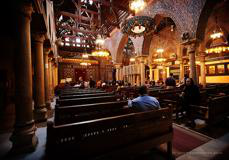

In [31]:
img = il[0]; img

# Split validation set

In [32]:
fn = il.items[0]; fn

PosixPath('/home/justin/.fastai/data/imagenette2-160/train/n03028079/n03028079_3064.JPEG')

In [33]:
fn.parent.parent.name

'train'

In [34]:
from functools import partial

In [35]:
from IPython.core.debugger import set_trace

In [36]:
def grandparent_splitter(fn, valid_name='valid', train_name='train'):
    gp = fn.parent.parent.name
    return True if gp==valid_name else False if gp==train_name else None

def split_by_func(items, f):
    mask = [f(o) for o in items]
    f = [o for o,m in zip(items,mask) if m==False]
    t = [o for o,m in zip(items,mask) if m==True ]
    return f, t

In [37]:
splitter = partial(grandparent_splitter, valid_name='val')

In [38]:
%time train,valid = split_by_func(il, splitter)

CPU times: user 21.7 ms, sys: 323 µs, total: 22 ms
Wall time: 21.9 ms


In [39]:
len(train), len(valid)

(9469, 3925)

In [40]:
class SplitData():
    def __init__(self, train, valid): self.train, self.valid = train,valid
        
    def __getattr__(self, k): return getattr(self.train, k)
    
    @classmethod
    def split_by_func(cls, il, f):
        lists = map(il.new, split_by_func(il.items, f))
        return cls(*lists)
    
    def __repr__(self): return f'{self.__class__.__name__}\nTrain: {self.train}\nValid: {self.valid}\n'

In [41]:
sd = SplitData.split_by_func(il, splitter); sd

SplitData
Train: ImageList (9469 items)
[PosixPath('/home/justin/.fastai/data/imagenette2-160/train/n03028079/n03028079_3064.JPEG'), PosixPath('/home/justin/.fastai/data/imagenette2-160/train/n03028079/n03028079_14604.JPEG'), PosixPath('/home/justin/.fastai/data/imagenette2-160/train/n03028079/n03028079_20439.JPEG'), PosixPath('/home/justin/.fastai/data/imagenette2-160/train/n03028079/n03028079_14278.JPEG'), PosixPath('/home/justin/.fastai/data/imagenette2-160/train/n03028079/n03028079_14957.JPEG'), PosixPath('/home/justin/.fastai/data/imagenette2-160/train/n03028079/n03028079_3967.JPEG'), PosixPath('/home/justin/.fastai/data/imagenette2-160/train/n03028079/n03028079_105285.JPEG'), PosixPath('/home/justin/.fastai/data/imagenette2-160/train/n03028079/n03028079_478.JPEG'), PosixPath('/home/justin/.fastai/data/imagenette2-160/train/n03028079/n03028079_39807.JPEG'), PosixPath('/home/justin/.fastai/data/imagenette2-160/train/n03028079/n03028079_44245.JPEG')...]
Path: /home/justin/.fastai/da

# Labelling

In [42]:
from collections import OrderedDict

def uniqueify(x, sort=False):
    res = list(OrderedDict.fromkeys(x).keys())
    if sort: res.sort()
    return res

In [43]:
class Processor(): 
    def process(self, items): return items

class CategoryProcessor(Processor):
    def __init__(self): self.vocab=None
    
    def __call__(self, items):
        #The vocab is defined on the first use.
        if self.vocab is None:
            self.vocab = uniqueify(items)
            self.otoi  = {v:k for k,v in enumerate(self.vocab)}
        return [self.proc1(o) for o in items]
    def proc1(self, item):  return self.otoi[item]
    
    def deprocess(self, idxs):
        assert self.vocab is not None
        return [self.deproc1(idx) for idx in idxs]
    def deproc1(self, idx): return self.vocab[idx]

In [44]:
def parent_labeler(fn): return fn.parent.name

def _label_by_func(ds, f, cls=ItemList): return cls([f(o) for o in ds.items], path=ds.path)

#This is a slightly different from what was seen during the lesson,
#   we'll discuss the changes in lesson 11
class LabeledData():
    def process(self, il, proc): return il.new(compose(il.items, proc))

    def __init__(self, x, y, proc_x=None, proc_y=None):
        self.x,self.y = self.process(x, proc_x),self.process(y, proc_y)
        self.proc_x,self.proc_y = proc_x,proc_y
        
    def __repr__(self): return f'{self.__class__.__name__}\nx: {self.x}\ny: {self.y}\n'
    def __getitem__(self,idx): return self.x[idx],self.y[idx]
    def __len__(self): return len(self.x)
    
    def x_obj(self, idx): return self.obj(self.x, idx, self.proc_x)
    def y_obj(self, idx): return self.obj(self.y, idx, self.proc_y)
    
    def obj(self, items, idx, procs):
        isint = isinstance(idx, int) or (isinstance(idx,torch.LongTensor) and not idx.ndim)
        item = items[idx]
        for proc in reversed(listify(procs)):
            item = proc.deproc1(item) if isint else proc.deprocess(item)
        return item

    @classmethod
    def label_by_func(cls, il, f, proc_x=None, proc_y=None):
        return cls(il, _label_by_func(il, f), proc_x=proc_x, proc_y=proc_y)

def label_by_func(sd, f, proc_x=None, proc_y=None):
    train = LabeledData.label_by_func(sd.train, f, proc_x=proc_x, proc_y=proc_y)
    valid = LabeledData.label_by_func(sd.valid, f, proc_x=proc_x, proc_y=proc_y)
    return SplitData(train,valid)

In [45]:
ll = label_by_func(sd, parent_labeler, proc_y=CategoryProcessor())

In [46]:
assert ll.train.proc_y is ll.valid.proc_y

In [47]:
ll

SplitData
Train: LabeledData
x: ImageList (9469 items)
[PosixPath('/home/justin/.fastai/data/imagenette2-160/train/n03028079/n03028079_3064.JPEG'), PosixPath('/home/justin/.fastai/data/imagenette2-160/train/n03028079/n03028079_14604.JPEG'), PosixPath('/home/justin/.fastai/data/imagenette2-160/train/n03028079/n03028079_20439.JPEG'), PosixPath('/home/justin/.fastai/data/imagenette2-160/train/n03028079/n03028079_14278.JPEG'), PosixPath('/home/justin/.fastai/data/imagenette2-160/train/n03028079/n03028079_14957.JPEG'), PosixPath('/home/justin/.fastai/data/imagenette2-160/train/n03028079/n03028079_3967.JPEG'), PosixPath('/home/justin/.fastai/data/imagenette2-160/train/n03028079/n03028079_105285.JPEG'), PosixPath('/home/justin/.fastai/data/imagenette2-160/train/n03028079/n03028079_478.JPEG'), PosixPath('/home/justin/.fastai/data/imagenette2-160/train/n03028079/n03028079_39807.JPEG'), PosixPath('/home/justin/.fastai/data/imagenette2-160/train/n03028079/n03028079_44245.JPEG')...]
Path: /home/ju

# Transform to tensor

In [48]:
import torch
import matplotlib.pyplot as plt

In [49]:
class ResizeFixed(Transform):
    _order=10
    def __init__(self, size):
        if isinstance(size,int): size=(size,size)
        self.size = size
    
    def __call__(self, item): return item.resize(self.size, PIL.Image.BILINEAR)
    
def to_byte_tensor(item):
    res = torch.ByteTensor(torch.ByteStorage.from_buffer(item.tobytes()))
    w,h = item.size
    return res.view(h,w,-1).permute(2,0,1)
to_byte_tensor._order=20

def to_float_tensor(item): return item.float().div_(255.)
to_float_tensor._order=30

In [50]:
tfms = [make_rgb, ResizeFixed(128), to_byte_tensor, to_float_tensor]

il = ImageList.from_files(path, tfms=tfms)
sd = SplitData.split_by_func(il, splitter)
ll = label_by_func(sd, parent_labeler, proc_y=CategoryProcessor())

In [51]:
def show_image(im, figsize=(3,3)):
    plt.figure(figsize=figsize)
    plt.axis('off')
    plt.imshow(im.permute(1,2,0))

In [52]:
x,y = ll.train[0]

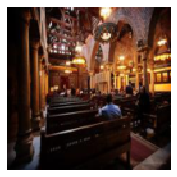

In [53]:
show_image(x)

# Modeling

In [54]:
from torch.utils.data import DataLoader

In [55]:
bs = 64

In [56]:
def get_dls(train_ds, valid_ds, bs, num_workers=1):
        return DataLoader(train_ds, batch_size=bs), DataLoader(valid_ds, batch_size=bs)

In [57]:
train_dl, valid_dl = get_dls(ll.train, ll.valid, bs, num_workers=4)

In [58]:
x,y = next(iter(train_dl))

In [59]:
x.shape

torch.Size([64, 3, 128, 128])

'n03028079'

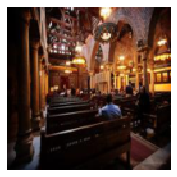

In [60]:
show_image(x[0])
ll.train.proc_y.vocab[y[0]]

In [61]:
y

tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [62]:
class DataBunch():
    def __init__(self, train_dl, valid_dl, c_in=None, c_out=None):
        self.train_dl, self.valid_dl, self.c_in, self.c_out = train_dl, valid_dl, c_in, c_out
        
    @property
    def train_ds(self): return self.train_dl.dataset
    
    @property
    def valid_ds(Self): return self.valid_dl.dataset

In [63]:
def databunchify(sd, bs, c_in=None, c_out=None, **kwargs):
    dls = get_dls(sd.train, sd.valid, bs, **kwargs)
    return DataBunch(*dls, c_in=c_in, c_out=c_out)

SplitData.to_databunch = databunchify

In [64]:
path = datasets.untar_data(datasets.URLs.IMAGENETTE_160)
tfms = [make_rgb, ResizeFixed(128), to_byte_tensor, to_float_tensor]

il = ImageList.from_files(path, tfms=tfms)
sd = SplitData.split_by_func(il, partial(grandparent_splitter, valid_name='val'))
ll = label_by_func(sd, parent_labeler, proc_y=CategoryProcessor())
data = ll.to_databunch(bs, c_in=3, c_out=10, num_workers=4)

In [65]:
data.train_ds

LabeledData
x: ImageList (9469 items)
[PosixPath('/home/justin/.fastai/data/imagenette2-160/train/n03028079/n03028079_3064.JPEG'), PosixPath('/home/justin/.fastai/data/imagenette2-160/train/n03028079/n03028079_14604.JPEG'), PosixPath('/home/justin/.fastai/data/imagenette2-160/train/n03028079/n03028079_20439.JPEG'), PosixPath('/home/justin/.fastai/data/imagenette2-160/train/n03028079/n03028079_14278.JPEG'), PosixPath('/home/justin/.fastai/data/imagenette2-160/train/n03028079/n03028079_14957.JPEG'), PosixPath('/home/justin/.fastai/data/imagenette2-160/train/n03028079/n03028079_3967.JPEG'), PosixPath('/home/justin/.fastai/data/imagenette2-160/train/n03028079/n03028079_105285.JPEG'), PosixPath('/home/justin/.fastai/data/imagenette2-160/train/n03028079/n03028079_478.JPEG'), PosixPath('/home/justin/.fastai/data/imagenette2-160/train/n03028079/n03028079_39807.JPEG'), PosixPath('/home/justin/.fastai/data/imagenette2-160/train/n03028079/n03028079_44245.JPEG')...]
Path: /home/justin/.fastai/data

# Model

In [66]:
class Callback():
    _order=0
    def set_runner(self, run): self.run = run
    def __getattr__(self, k): return getattr(self.run, k)
    
    @property
    def name(self):
        name = re.sub(r'Callback$', '', self.__class__.__name__)
        return camel2snake(name or 'callback')
    
    def __call__(self, cb_name):
        f = getattr(self, cb_name, None)
        if f and f(): return True
        return False

In [67]:
def accuracy(out, yb): return (torch.argmax(out, dim=1)==yb).float().mean()

In [68]:
class AvgStats():
    def __init__(self, metrics, in_train):
        self.metrics, self.in_train = listify(metrics), in_train
        
    def reset(self):
        self.tot_loss, self.count = 0,0
        self.tot_mets = [0] * len(self.metrics)

    @property
    def all_stats(self): return [self.tot_loss.item()] + self.tot_mets
    @property
    def avg_stats(self): return [o/self.count for o in self.all_stats]

    def __repr__(self):
        if not self.count: return ""
        return f"{'train' if self.in_train else 'valid'}: {self.avg_stats}"

    def accumulate(self, run):
        bn = run.xb.shape[0]
        self.tot_loss += run.loss * bn
        self.count += bn
        for i,m in enumerate(self.metrics):
            self.tot_mets[i] += m(run.pred, run.yb) * bn

class AvgStatsCallback(Callback):
    def __init__(self, metrics):
        self.train_stats, self.valid_stats = AvgStats(metrics, True), AvgStats(metrics,False)

    def begin_epoch(self):
        self.train_stats.reset()
        self.valid_stats.reset()

    def after_loss(self):
        stats = self.train_stats if self.in_train else self.valid_stats
        with torch.no_grad(): stats.accumulate(self.run)

    def after_epoch(self):
        print(self.train_stats)
        print(self.valid_stats)

In [69]:
class CudaCallback(Callback):
    def __init__(self, device=torch.device('cuda',0)): 
        self.device=device
    def begin_fit(self): self.model.to(device)
    def begin_batch(self): self.run.xb, self.run.yb = self.xb.to(device), self.yb.to(device)

In [70]:
def accuracy(out, yb): return (torch.argmax(out, dim=1)==yb).float().mean()

In [71]:
cbfs = [partial(AvgStatsCallback, accuracy), CudaCallback]

In [72]:
m,s = x.mean((0,2,3)).cuda(), x.std((0,2,3)).cuda()
m,s

(tensor([0.4404, 0.4345, 0.4112], device='cuda:0'),
 tensor([0.2780, 0.2765, 0.3065], device='cuda:0'))

In [73]:
import torch.tensor as tensor

In [74]:
def normalize_chan(x, mean, std):
    return (x-mean[...,None,None]) / std[...,None,None]

_m = tensor([0.47, 0.48, 0.45])
_s = tensor([0.29, 0.28, 0.30])

norm_imagenette = partial(normalize_chan, mean=_m.cuda(), std=_s.cuda())

In [75]:
class BatchTransformXCallback(Callback):
    _order=2
    def __init__(self, tfm): self.tfm = tfm
    def begin_batch(self): self.run.xb = self.tfm(self.xb)
    
def view_tfm(*size):
    def _inner(x): return x.view(*((-1,)+size))
    return _inner

In [76]:
cbfs.append(partial(BatchTransformXCallback, norm_imagenette))

In [77]:
nfs = [64,64,128,256]

In [78]:
def conv_layer(ni, nf, ks=3, stride=2, bn=True, **kwargs):
    layers = [nn.Conv2d(ni, nf, ks, padding=ks//2, stride=stride, bias=not bn),
              GeneralRelu(**kwargs)]
    if bn: layers.append(BatchNorm(nf))
    return nn.Sequential(*layers)

class GeneralRelu(nn.Module):
    def __init__(self, leak=None, sub=None, maxv=None):
        super().__init__()
        self.leak, self.sub, self.maxv = leak, sub, maxv
        
    def forward(self, x):
        x = F.leaky_relu(x, self.leak) if self.leak is not None else F.relu(x)
        if self.sub is not None: x.sub_(self.sub)
        if self.maxv is not None: x.clamp_max_(self.maxv)
        return x
    
class BatchNorm(nn.Module):
    def __init__(self, nf, mom=0.1, eps=1e-5):
        super().__init__()
        self.mom, self.eps = mom, eps
        self.mults = nn.Parameter(torch.ones (nf, 1, 1))
        self.adds  = nn.Parameter(torch.zeros(nf, 1,1 ))
        self.register_buffer('vars',  torch.ones(1,nf,1,1))
        self.register_buffer('means', torch.zeros(1,nf,1,1))
        
    def update_stats(self, x):
        m = x.mean((0,2,3), keepdim=True)
        v = x.var ((0,2,3), keepdim=True)
        self.means.lerp_(m, self.mom)
        self.vars.lerp_(v,  self.mom)
        return m,v
    
    def forward(self, x):
        if self.training:
            with torch.no_grad(): m,v = self.update_stats(x)
        else: m,v = self.means, self.vars
        x = (x-m) / (v + self.eps).sqrt()
        return x*self.mults + self.adds
    
class Lambda(nn.Module):
    def __init__(self, func):
        super().__init__()
        self.func = func
        
    def forward(self, x): return self.func(x)
    
def flatten(x): return x.view(x.shape[0], -1)

def init_cnn(m, uniform=False):
    f = init.kaiming_uniform_ if uniform else init.kaiming_normal_
    for l in m:
        if isinstance(l, nn.Sequential):
            f(l[0].weight, a=0.1)
            if hasattr(l[0], 'bias') and l[0].bias is not None:
                l[0].bias.data.zero_()

In [79]:
def prev_pow_2(x): return 2**math.floor(math.log2(x))

def get_cnn_layers(data, nfs, layer, **kwargs):
    def f(ni, nf, stride=2): return layer(ni, nf, 3, stride=stride, **kwargs)
    l1 = data.c_in
    l2 = prev_pow_2(l1*3*3)
    layers = [f(l1, l2,     stride=1),
              f(l2, l2*2,   stride=2),
              f(l2*2, 12*4, stride=2)]
    nfs = [12*4] + nfs
    layers += [f(nfs[i], nfs[i+1]) for i in range(len(nfs)-1)]
    layers += [nn.AdaptiveAvgPool2d(1), Lambda(flatten),
               nn.Linear(nfs[-1], data.c_out)]
    return layers

def get_cnn_model(data, nfs, layer, **kwargs):
    return nn.Sequential(*get_cnn_layers(data, nfs, layer, **kwargs))

def get_learn_run(nfs, data, lr, layer, cbs=None, opt_func=None, **kwargs):
    model = get_cnn_model(data, nfs, layer, **kwargs)
    init_cnn(model)
    return get_runner(model, data, lr=lr, cbs=cbs, opt_func=opt_func)

In [80]:
def combine_scheds(pcts, scheds):
    assert sum(pcts) == 1
    pcts = tensor([0] + listify(pcts))
    assert torch.all(pcts >= 0)
    pcts = torch.cumsum(pcts, 0)
    def _inner(pos):
        idx = (pos >= pcts).nonzero().max()
        actual_pos = (pos-pcts[idx]) / (pcts[idx+1]-pcts[idx])
        return scheds[idx](actual_pos)
    return _inner

In [81]:
def annealer(f):
    def _inner(start, end): return partial(f, start, end)
    return _inner

@annealer
def sched_lin(start, end, pos): return start + pos*(end-start)

In [82]:
@annealer
def sched_cos(start, end, pos): return start + (1 + math.cos(math.pi*(1-pos))) * (end-start) / 2

@annealer
def sched_no(start, end, pos): return start

@annealer
def sched_exp(start, end, pos): return start * (end/start) ** pos

torch.Tensor.ndim = property(lambda x: len(x.shape))

In [83]:
def cos_1cycle_anneal(start, high, end):
    return [sched_cos(start, high), sched_cos(high, end)]

In [84]:
sched = combine_scheds([0.3, 0.7], cos_1cycle_anneal(0.1,0.3,0.05))

In [85]:
class ParamScheduler(Callback):
    _order=1
    def __init__(self, pname, sched_func): self.pname, self.sched_func = pname, sched_func
        
    def set_param(self):
        for pg in self.opt.param_groups:
            pg[self.pname] = self.sched_func(self.n_epochs/self.epochs)
    
    def begin_batch(self):
        if self.in_train: self.set_param()
            
class TrainEvalCallback(Callback):
    def begin_fit(self):
        self.run.n_epochs = 0
        self.run.n_iter = 0
        
    def after_batch(self):
        if not self.in_train: return
        self.run.n_epochs += 1./self.iters
        self.run.n_iter   += 1
        
    def begin_epoch(self):
        self.run.n_epochs=self.epoch
        self.model.train()
        self.run.in_train=True
        
    def begin_validate(self):
        self.model.eval()
        self.run.in_train=False

In [86]:
def get_runner(model, data, lr=0.6, cbs=None, opt_func=None, loss_func = F.cross_entropy):
    if opt_func is None: opt_func = optim.SGD
    opt = opt_func(model.parameters(), lr=lr)
    learn = Learner(model, opt, loss_func, data)
    return learn, Runner(cb_funcs=listify(cbs))

In [87]:
class Learner():
    def __init__(self, model, opt, loss_func, data):
        self.model, self.opt, self.loss_func, self.data = model,opt,loss_func,data

In [88]:
class Runner():
    def __init__(self, cbs=None, cb_funcs=None):
        cbs = listify(cbs)
        for cbf in listify(cb_funcs):
            cb = cbf()
            setattr(self, cb.name, cb)
            cbs.append(cb)
        self.stop, self.cbs = False, [TrainEvalCallback()]+cbs
        
    @property
    def opt(self):       return self.learn.opt
    @property
    def model(self):     return self.learn.model
    @property
    def loss_func(self): return self.learn.loss_func
    @property
    def data(self):      return self.learn.data
    
    def one_batch(self, xb, yb):
        self.xb, self.yb = xb, yb
        if self('begin_batch'): return
        self.pred = self.model(self.xb)
        if self('after_pred'): return
        self.loss = self.loss_func(self.pred, self.yb)
        if self('after_loss') or not self.in_train: return
        self.loss.backward()
        if self('after_backward'): return
        self.opt.step()
        if self('after_step'): return
        self.opt.zero_grad()
        
    def all_batches(self, dl):
        self.iters = len(dl)
        for xb,yb in dl:
            if self.stop: break
            self.one_batch(xb, yb)
            self('after_batch')
            self.stop=False
            
    def fit(self, epochs, learn):
        self.epochs, self.learn = epochs, learn
        
        try:
            for cb in self.cbs: cb.set_runner(self)
            if self('begin_fit'): return
            for epoch in range(epochs):
                self.epoch = epoch
                if not self('begin_epoch'): self.all_batches(self.data.train_dl)
                    
                with torch.no_grad():
                    if not self('begin_validate'): self.all_batches(self.data.valid_dl)
                if self('after_epoch'): break
                    
        finally:
            self('after_fit')
            self.learn = None
            
    def __call__(self, cb_name):
        for cb in sorted(self.cbs, key=lambda x:x._order):
            f = getattr(cb, cb_name, None)
            if f and f(): return True
        return False

In [89]:
import re

_camel_re1 = re.compile('(.)([A-Z][a-z]+)')
_camel_re2 = re.compile('([a-z0-9])([A-Z])')
def camel2snake(name):
    s1 = re.sub(_camel_re1, r'\1_\2', name)
    return re.sub(_camel_re2, r'\1_\2', s1).lower()

class Callback():
    _order=0
    def set_runner(self, run): self.run=run
    def __getattr__(self, k): return getattr(self.run, k)
    @property
    def name(self):
        name = re.sub(r'Callback$', '', self.__class__.__name__)
        return camel2snake(name or 'callback')

In [90]:
learn, run = get_learn_run(nfs, data, 0.2, conv_layer, cbs=cbfs+[
    partial(ParamScheduler, 'lr', sched)
])

In [91]:
def get_batch(dl, run):
    run.xb, run.yb = next(iter(dl))
    for cb in run.cbs: cb.set_runner(run)
    run('begin_batch')
    return run.xb, run.yb

In [92]:
def children(m): return list(m.children())

class Hook():
    def __init__(self, m, f): self.hook = m.register_forward_hook(partial(f, self))
    def remove(self): self.hook.remove()
    def __del__(self): self.remove()

In [93]:
class Hooks(ListContainer):
    def __init__(self, ms, f): super().__init__([Hook(m,f) for m in ms])
    def __enter__(self, *args): return self
    def __exit__ (self, *args): self.remove()
    def __del__(self): self.remove()
        
    def __delitem__(self, i):
        self[i].remove()
        super().__delitem__(i)
        
    def remove(self):
        for h in self: h.remove()

In [94]:
def model_summary(run, learn, find_all=False):
    xb, yb = get_batch(data.valid_dl, run)
    device = next(learn.model.parameters()).device
    xb, yb = xb.to(device), yb.to(device)
    mods = find_modules(learn.model, is_lin_layer) if find_all else learn.model.children()
    f = lambda hook, mod, inp, out: print(f'{mod}\n{out.shape}\n')
    with Hooks(mods, f) as hooks: learn.model(xb)

In [95]:
model_summary(run, learn)

AttributeError: 'Runner' object has no attribute 'in_train'

In [ ]:
%debug

> <ipython-input-66-de2c5b66a101>(4)__getattr__()
      2     _order=0
      3     def set_runner(self, run): self.run = run
----> 4     def __getattr__(self, k): return getattr(self.run, k)
      5 
      6     @property

ipdb> u
> <ipython-input-85-255893f7e4ed>(10)begin_batch()
      8 
      9     def begin_batch(self):
---> 10         if self.in_train: self.set_param()
     11 
     12 class TrainEvalCallback(Callback):

ipdb> self.run.in_train
*** AttributeError: 'Runner' object has no attribute 'in_train'
ipdb> self.run
ipdb> dir(self.run)
['__call__', '__class__', '__delattr__', '__dict__', '__dir__', '__doc__', '__eq__', '__format__', '__ge__', '__getattribute__', '__gt__', '__hash__', '__init__', '__init_subclass__', '__le__', '__lt__', '__module__', '__ne__', '__new__', '__reduce__', '__reduce_ex__', '__repr__', '__setattr__', '__sizeof__', '__str__', '__subclasshook__', '__weakref__', 'all_batches', 'avg_stats', 'batch_transform_x', 'cbs', 'cuda', 'data', 'fit', 'loss_func'

In [ ]:
%time run.fit(5, learn)

# Optimizer Tweaks

In [ ]:
path = datasets.untar_data(datasets.URLs.IMAGENETTE_160)

In [ ]:
tfms = [make_rgb, ResizeFixed(128), to_byte_tensor, to_float_tensor]
bs = 128

il = ImageList.from_files(path, tfms=tfms)
sd = SplitData.split_by_func(il, partial(grandparent_splitter, valid_name='val'))
ll = label_by_func(sd, parent_labeler, proc_y=CategoryProcessor())
data = ll.to_databunch(bs, c_in=3, c_out=10, num_workers=4)

In [ ]:
nfs = [32, 64, 128, 256]

In [ ]:
cbfs = [partial(AvgStatsCallback, accuracy), CudaCallback,
        partial(BatchTransformXCallback, norm_imagenette)]

In [ ]:
learn, run = get_learn_run(nfs, data, 0.4, conv_layer, cbs=cbfs)

In [ ]:
run.fit(1, learn)

# Refine optimizer

In [ ]:
class Optimizer():
    def __init__(self, params, steppers, **defaults):
        self.param_groups = list(params)
        if not isinstance(self.param_groups[0], list):
            self.param_groups = [self.param_groups]
        self.hypers = [{**defaults} for p in self.param_groups]
        self.steppers = listify(steppers)
        
        set_trace()
        
    def grad_params(self):
        return [(p, hyper) for pg, hyper in zip(self.param_groups, self.hypers)
               for p in pg if p.grad is not None]

    def zero_grad(self):
        for p,hyper in self.grad_params():
            p.grad.detach_()
            p.grad.zero_()
            
    def step(self):
        for p, hyper in self.grad_params():
            compose(p, self.steppers, **hyper)

In [ ]:
def sgd_step(p, lr, **kwargs):
    p.data.add_(-lr, p.grad.data)
    return p

In [ ]:
opt_func = partial(Optimizer, steppers=[sgd_step])

In [ ]:
learn, run = get_learn_run(nfs, data, 0.4, conv_layer, cbs=cbfs, opt_func = opt_func)

In [ ]:
run.fit(1, learn)

In [ ]:
class Recorder(call)